In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
for key in meta:
    if 'badEmoid' in meta[key]:
        print(key)

601983541597


In [3]:
import numpy as np

# Load emoid data

nEmoid = 0
nt = -1

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        nEmoid += 1
        nt = meta[key]['emoidData'].shape[1]

ts_emoid = np.zeros([nEmoid,264,nt])
c = 0

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        ts_emoid[c] = meta[key]['emoidData']
        c += 1

print(nEmoid)
print('Complete')

678
Complete


In [10]:
import torch

# Convert to PyTorch

ts_emoid_t = torch.from_numpy(ts_emoid).float().cuda()

print('Complete')

Complete


In [87]:
# Set up a parameter sharing Discrete Markov Causal Model

import torch.nn as nn
import torch.nn.functional as F

class Sharing1(nn.Module):
    def __init__(self):
        super(Sharing1, self).__init__()
        self.s0 = nn.Parameter(0.1*torch.randn(264,120).float().cuda())
        self.p0 = nn.Parameter(0.1*torch.randn(nEmoid-1,264,120).float().cuda())
        self.s1 = nn.Parameter(0.1*torch.randn(240,150).float().cuda())
        self.p1 = nn.Parameter(0.1*torch.randn(nEmoid-1,240,150).float().cuda())
        self.last = nn.Parameter(0.1*torch.randn(300,264).float().cuda())
        self.loss = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        xs = F.relu(torch.einsum('nrt,rs->nst',x,self.s0))
        xp = F.relu(torch.einsum('nrt,nrp->npt',x,self.p0))
        x = torch.cat([xs,xp], dim=1)
        xs = F.relu(torch.einsum('nrt,rs->nst',x,self.s1))
        xp = F.relu(torch.einsum('nrt,nrp->npt',x,self.p1))
        x = torch.cat([xs,xp], dim=1)
        x = torch.einsum('nht,hr->nrt',x,self.last)
        return x
    
sharing = Sharing1()
optim = torch.optim.Adam(sharing.parameters(), lr=2e-3, weight_decay=0)

nEpoch = 3000
pPrint = 100

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = sharing(ts_emoid_t[:-1])
    loss = sharing.loss(pred, ts_emoid_t[1:])
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print('Complete')

epoch 0 loss=0.04474881663918495
epoch 100 loss=0.006413942668586969
epoch 200 loss=0.005140889436006546
epoch 300 loss=0.004691245965659618
epoch 400 loss=0.00436996016651392
epoch 500 loss=0.004154379013925791
epoch 600 loss=0.003998503554612398
epoch 700 loss=0.003877028124406934
epoch 800 loss=0.003777681617066264
epoch 900 loss=0.0036946048494428396
epoch 1000 loss=0.003624954726547003
epoch 1100 loss=0.003565615275874734
epoch 1200 loss=0.003514779033139348
epoch 1300 loss=0.0034706839360296726
epoch 1400 loss=0.003433873876929283
epoch 1500 loss=0.0033989273943006992
epoch 1600 loss=0.003368944860994816
epoch 1700 loss=0.003343048971146345
epoch 1800 loss=0.003318660194054246
epoch 1900 loss=0.003296302631497383
epoch 2000 loss=0.003276171861216426
epoch 2100 loss=0.003258165204897523
epoch 2200 loss=0.003242309670895338
epoch 2300 loss=0.0032276830170303583
epoch 2400 loss=0.003210351336747408
epoch 2500 loss=0.003196961944922805
epoch 2600 loss=0.003183694090694189
epoch 2700 

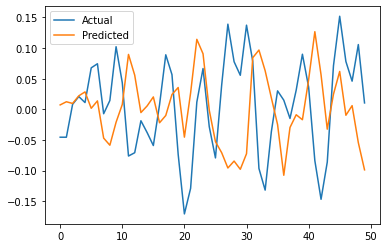

In [89]:
import matplotlib.pyplot as plt

sub1 = pred[0].detach().cpu().numpy()

plt.plot(ts_emoid[0,120,1:51], label='Actual')
plt.plot(sub1[120,:50], label='Predicted')
plt.legend()
plt.show()

In [18]:
print(sub1.shape)

(264, 210)


In [20]:
print(sharing.loss(pred,ts_emoid_t[1:]))

tensor(10.6427, device='cuda:0', grad_fn=<MseLossBackward0>)
